# Atividade de implementação e teste do Perceptron - Questão 1







**Nome:** Dimitri Leandro de Oliveira Silva

**RA:** 11201720576

## Enunciado:

1) Utilizando o algoritmo do perceptron, realize testes com os dados fornecidos nos arquivos dataset1.txt a dataset6.txt. Comente os resultados obtidos, incluindo observações sobre: Influência do passo de adaptação, Convergência do algoritmo, Critério de Parada (e se foi necessário alterá-lo). Para ajudar, ilustre com gráficos da evolução dos pesos do perceptron (valor do peso x # iteração).

## Sobre as Implementações

Em primeiro lugar, implementou-se uma classe chamada **Neuron**. Essa é a classe que contém todo o algoritmo do Perceptron, responsável por receber um conjunto de dados e atualizar os pesos referentes a cada entrada, incluindo o bias, por várias épocas até que o critério de parada seja atingido. A função de ativação utilizada foi o degrau unitário, isto é, o neurônio só é ativado caso a entrada líquida seja maior que 0.

Entretanto, essa classe possui o problema da classificação binária, ou seja, o algoritmo implementado só consegue classificar datasets que contenham apenas duas classes. Para solucionar esse problema, implementou-se a classe **MultiNeuron**. Essa classe instancia um objeto da classe **Neuron** para cada classe do dataset, ainda que seja um dataset binário.

A princípio, só seria necessário utilizar **Qtd de Classes - 1** neurônios, assim, as primeiras classes teriam o seu próprio neurônio, exceto a última, que só seria escolhida caso nenhum dos outros neurônios fosse ativado. Todavia, em diversos testes previamente realizados, observou-se dois pontos importantes: 1) as vezes mais de um neurônio era ativado ao mesmo tempo para classificar uma única amostra; 2) Um dado pertencente à última classe (a que não possui um neurônio) estaria suscetível ao erro de todos os outros neurônios antes de finalmente ser atribuído à classe correta. Por esses dois motivos, desejou-se implementar a classe **MultiNeuron** de forma que todas as classes recebessem um neurônio. Assim, a última classe não seria tão injustiçada.

Nos casos de empate, isto é, caso mais de um neurônio for ativado ao mesmo tempo para uma mesma amostra, é escolhido aquele com a maior entrada líquida. Três critérios de parada foram definidos. Um neurônio só interrompe seu treinamento caso: 1) a acurácia de treinamento tenha atingido 100% (convergência); 2) o número de épocas tiver chegado no limite determinado; 3) a acurácia de treinamento não tiver melhorado nas últimas **J** iterações, sendo __J__ equivalente a um percentual do limite de épocas determinado no item 2.

Os únicos pacotes utilizados durante as implementações foram: Numpy, Random e Joblib.

## Importando os pacotes necessários

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from sklearn.metrics import accuracy_score

sys.path.append("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Perceptron/python/")
from MultiNeuronClass import MultiNeuron

pd.options.mode.chained_assignment = None

## Definindo algumas funções

In [2]:
def plotarDataset(dataframe, nome):
    
    %matplotlib inline
    %config InlineBackend.figure_format = 'svg'
    params = {'figure.figsize': [10, 5], 
              'figure.titlesize': 16,
              'axes.labelsize': 12,
              'axes.titlesize':14, 
              'font.size': 12,
              'legend.fontsize': 12, 
              'xtick.labelsize': 10, 
              'ytick.labelsize': 10
             }
    plt.rcParams.update(params)
    
    plt.scatter(dataframe["feature1"], dataframe["feature2"], c=dataframe["classe"], s=300, alpha=0.75)
    plt.title(nome)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True, alpha=0.5)    
    plt.show()

In [3]:
def plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron):
    colunas = ["Taxa de Aprendizagem", "Neurônio", "Total de Épocas", "Acurácia de Treinamento", "Critério de Parada"]
    data    = []

    for i, taxaAtual in enumerate(arrayValoresTaxaAprendizagem):    
        for j, neuronioAtual in enumerate(arrayObjMultiNeuron[i].arrayNeuronios):
            linha = [taxaAtual, j+1, neuronioAtual.qtdIteracoes, max(neuronioAtual.evolucaoAcuracias), neuronioAtual.motivoParada]
            data.append(linha)

    return pd.DataFrame(data=data, columns=colunas).style.hide_index()

In [4]:
def plotarEvolucaoAcuracias(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron):
    
    %matplotlib inline
    %config InlineBackend.figure_format = 'svg'
    params = {'figure.figsize': [12, 2.5], 
              'figure.titlesize': 10,
              'axes.labelsize': 6,
              'axes.titlesize':8, 
              'font.size': 8,
              'legend.fontsize': 6, 
              'xtick.labelsize': 4, 
              'ytick.labelsize': 4
             }
    plt.rcParams.update(params)
    
    for i, taxaAtual in enumerate(arrayValoresTaxaAprendizagem):
    
        fig, axs = plt.subplots(1, len(arrayObjMultiNeuron[i].arrayNeuronios))

        for j, neuronioAtual in enumerate(arrayObjMultiNeuron[i].arrayNeuronios):

            axs[j].plot(neuronioAtual.evolucaoAcuracias)
            axs[j].set_title("Neurônio " + str(j+1))
            axs[j].set_xlabel("Época")
            axs[j].set_ylabel("Acurácia")
            axs[j].set_ylim(0, 1)
            axs[j].grid(alpha=0.5)

        fig.suptitle('Taxa de Aprendizagem: ' + str(taxaAtual))
        plt.show()

In [42]:
def plotarEvolucaoPesos(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron):
    
    %matplotlib inline
    %config InlineBackend.figure_format = 'svg'
    params = {'figure.figsize': [12, 2.5], 
              'figure.titlesize': 10,
              'axes.labelsize': 6,
              'axes.titlesize':8, 
              'font.size': 8,
              'legend.fontsize': 6, 
              'xtick.labelsize': 4, 
              'ytick.labelsize': 4
             }
    plt.rcParams.update(params)
    
    for i, taxaAtual in enumerate(arrayValoresTaxaAprendizagem):
    
        fig, axs = plt.subplots(1, len(arrayObjMultiNeuron[i].arrayNeuronios))

        for j, neuronioAtual in enumerate(arrayObjMultiNeuron[i].arrayNeuronios):

            for k, evolucaoPesoAtual in enumerate(neuronioAtual.evolucaoPesos):
                axs[j].plot(evolucaoPesoAtual, label="Peso " + str(k+1))
            
            axs[j].set_title("Neurônio " + str(j+1))
            axs[j].set_xlabel("Época")
            axs[j].set_ylabel("Valor")
            axs[j].grid(alpha=0.5)
            axs[j].legend()

        fig.suptitle('Taxa de Aprendizagem: ' + str(taxaAtual) + "\n")
        plt.show()

## Importando os datasets

In [6]:
colunas  = ["feature1", "feature2", "classe"]

dataset1 = pd.read_csv("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Datasets/dataset1.txt", names=colunas, sep=' ', header=None)
dataset2 = pd.read_csv("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Datasets/dataset2.txt", names=colunas, sep=' ', header=None)
dataset3 = pd.read_csv("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Datasets/dataset3.txt", names=colunas, sep=' ', header=None)
dataset4 = pd.read_csv("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Datasets/dataset4.txt", names=colunas, sep=' ', header=None)
dataset5 = pd.read_csv("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Datasets/dataset5.txt", names=colunas, sep=' ', header=None)
dataset6 = pd.read_csv("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Datasets/dataset6.txt", names=colunas, sep=' ', header=None)

datasets = [dataset1, dataset2, dataset3, dataset4, dataset5, dataset6]

## Corrigindo os datasets

Os datasets contém as classes 1, 2, 3... Elas não começam em 0, e isso é um problema pra implementação própria. Então só é preciso fazer com que a classe 1 se torne classe 0, classe 2 se torne classe 1 e assim por diante.

In [7]:
for i, datasetAtual in enumerate(datasets):
    for j, classeAtual in enumerate(datasetAtual["classe"]):
        datasets[i]["classe"][j] = classeAtual - 1

## Analisando a evolução dos neurônios durante o treinamento

Nessa seção, os datasets de 1 a 6 serão utilizados para avaliar a evolução dos neurônios durante a etapa de treinamento. Para diversos valores de **taxa de aprendizagem**, serão exibidos: 1) critério de parada de cada neurônio; 2) acurácia de treinamento; 3) quantidade de épocas de treinamento; 4) evolução dos pesos em função das épocas; 5) evolução das acurácias de treinamento em função das épocas. Em todos os casos, **todos** os dados foram utilziados no treinamento. Testes com validação cruzada serão efetuados mais adiante.

### Dataset 1

In [8]:
datasetAtual = 1

#### Visualização

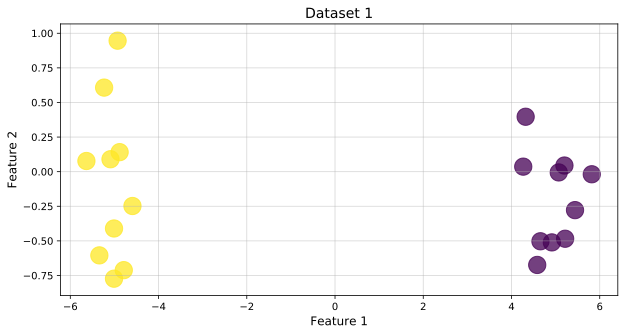

In [9]:
plotarDataset(datasets[datasetAtual-1], "Dataset " + str(datasetAtual))

Por possuir duas classes, dois neurônios serão utilizados. Espera-se que uma acurácia de 100% seja atingida. Afinal, a imagem acima mostra claramente que o dataset é linearmente separável.

#### Treinamento com todos os dados

A célula abaixo instancia um objeto da classe **MultiNeuron** e faz o treinamento com todos os dados disponíveis no dataset para diversos valores de **taxa de aprendizagem**. É possível definir a quantidade máxima permitida de épocas de treinamento caso se deseje. Esse valor foi fixado em 1000 iterações. Também é possível determinar o percentual da quantidade máxima de épocas que deve ser considerado para parar o treinamento caso a acurácia não melhore nesse percentual de iterações.

In [10]:
# QUANTIDADE MAXIMA DE EPOCAS DE TREINAMENTO
qtdMaxEpocas         = 1000
percentualSemMelhora = 0.35

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = datasets[datasetAtual-1][["feature1", "feature2"]].values
y = datasets[datasetAtual-1]["classe"].values

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

# ARRAY PARA GUARDAR OS OBJETOS MULTINEURON DE CADA TAXA DE APRENDIZAGEM
arrayObjMultiNeuron = []

# PARA CADA VALOR DA TAXA DE APRENDIZAGEM
for taxaAtual in arrayValoresTaxaAprendizagem:
    objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, qtdMaxEpocas=qtdMaxEpocas, percentualSemMelhora=percentualSemMelhora, armazenarEvolucaoNeuronios=True)
    objMultiNeuron.treinar(x, y)
    arrayObjMultiNeuron.append(objMultiNeuron)

#### Critério de parada de cada neurônio para cada taxa de aprendizagem

In [11]:
resultado = plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)
resultado

Verifica-se que todos neurônios de todas as taxas de aprendizagem convergiram para 100% em pouquíssimas épocas, como esperado. Essa comportamento só é possível em datasets que sejam linearmente separáveis.

#### Evolução das acurácias de treinamento e dos pesos

Como o algoritmo convergiu muito rapidamente, a evolução da acurácia de treinamento será mostrada apenas nos datasets seguintes, bem como a evolução dos pesos.

### Dataset 2

In [12]:
datasetAtual = 2

#### Visualização

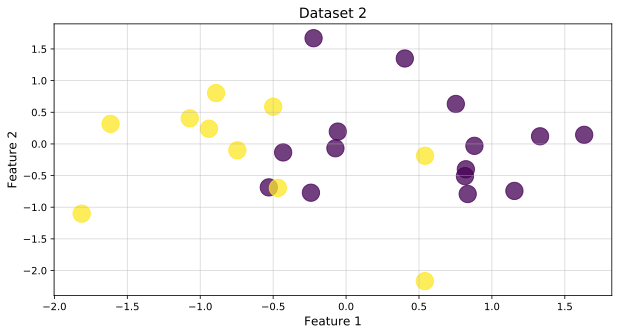

In [13]:
plotarDataset(datasets[datasetAtual-1], "Dataset " + str(datasetAtual))

Dessa vez, percebe-se visualmente que o dataset não é linearmente separável. As acurácias deverão ficar um pouco abaixo de 100%.

#### Treinamento com todos os dados

In [14]:
# QUANTIDADE MAXIMA DE EPOCAS DE TREINAMENTO
qtdMaxEpocas = 1000
percentualSemMelhora = 0.35

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = datasets[datasetAtual-1][["feature1", "feature2"]].values
y = datasets[datasetAtual-1]["classe"].values

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

# ARRAY PARA GUARDAR OS OBJETOS MULTINEURON DE CADA TAXA DE APRENDIZAGEM
arrayObjMultiNeuron = []

# PARA CADA VALOR DA TAXA DE APRENDIZAGEM
for taxaAtual in arrayValoresTaxaAprendizagem:
    objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, qtdMaxEpocas=qtdMaxEpocas, percentualSemMelhora=percentualSemMelhora, armazenarEvolucaoNeuronios=True)
    objMultiNeuron.treinar(x, y)
    arrayObjMultiNeuron.append(objMultiNeuron)

#### Critério de parada de cada neurônio para cada taxa de aprendizagem

In [15]:
resultado = plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)
resultado

Como esperado, nenhum neurônio conseguiu separar completamente a classe atribuida para si. Aparentemente os casos com taxa de aprendizagem de 1e-3 e 1e-2 foram os que obtiveram as melhores acurácias. 

Diferentemente do dataset anterior, o critério de parada mais acionado nesse caso foi o do percentual do máximo de épocas atingido sem qualquer melhoria na acurácia de treinamento. Como o total de épocas foi de 1000, então isso significa que os neurônios ficaram 350 épocas sem melhorias na acurácia de treinamento. Ao final, as classes implementadas escolhem os pesos que garantiram a melhor acurácia durante o treinamento.

#### Evolução das acurácias de treinamento e dos pesos

Os gráficos abaixo mostrarão a evolução das acurácias de treinamento em função das épocas. Mais adiante será exibido a evolução dos pesos.

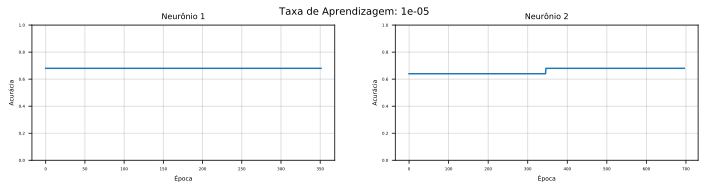

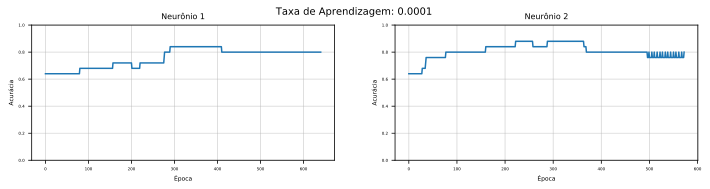

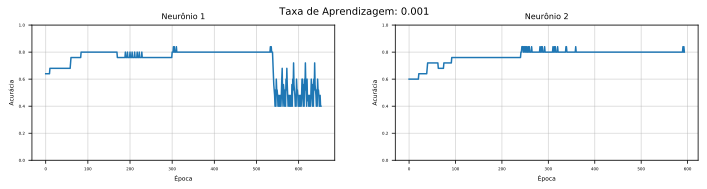

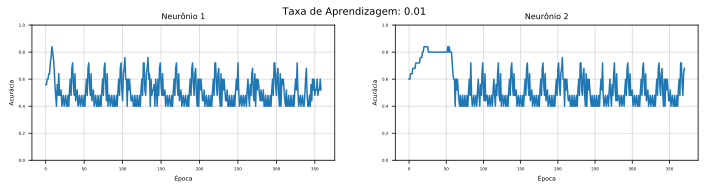

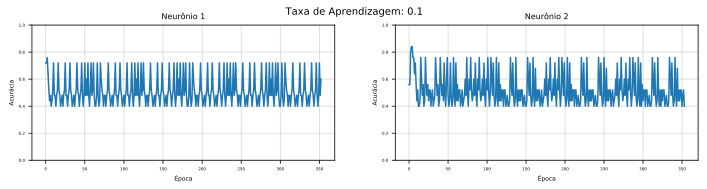

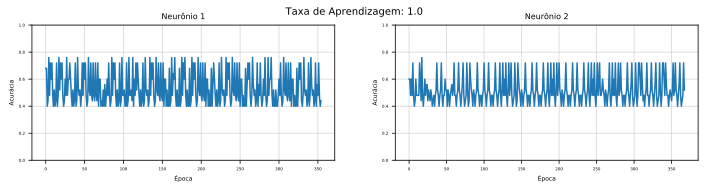

In [16]:
plotarEvolucaoAcuracias(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

Sobre a evolução das acurácias de treinamento, verifica-se que quanto maior a taxa de aprendizagem, maior é a variância dos neurônios. Entretanto, uma taxa muito baixa pode acabar não apresentando melhorias significativas, como foi o caso da taxa de 1e-5.

Para taxas muito altas, como a de 1, observa-se que a acurácia de treinamento, na verdade, nunca melhorou. O passo de adaptação foi tão alto que a acurácia sempre atingia os mesmos valores de mínimo e máximo, não saindo do lugar.

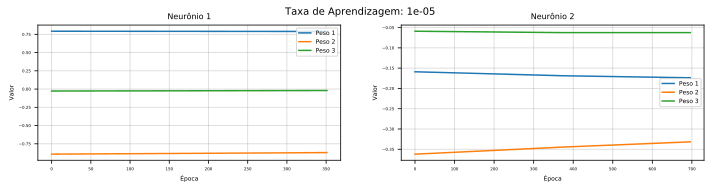

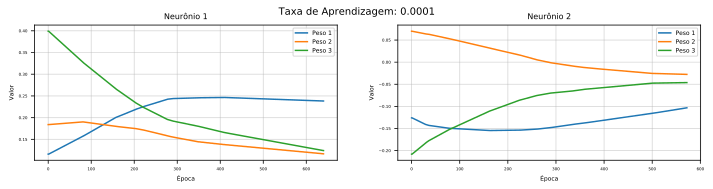

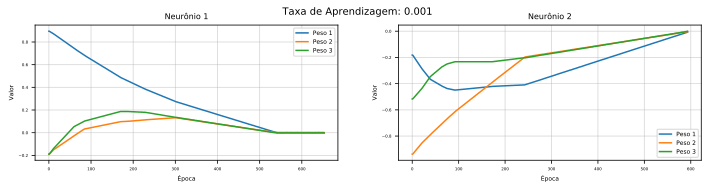

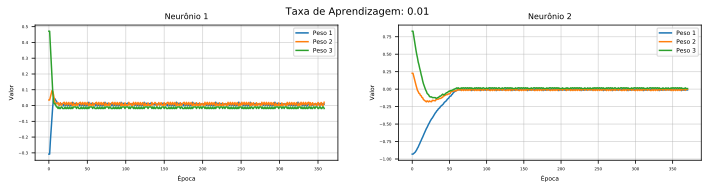

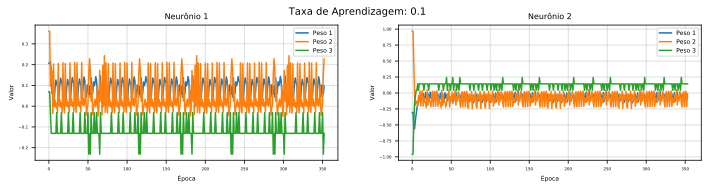

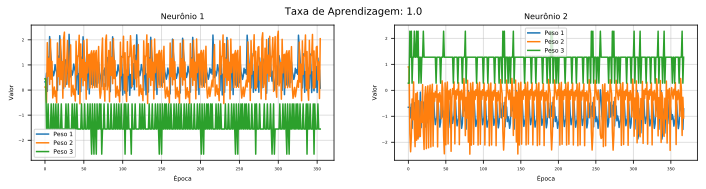

In [17]:
plotarEvolucaoPesos(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

Quanto à evolução dos pesos, o mesmo fenômeno se repete: quanto maior a taxa de aprendizagem, maior a variância. Ainda assim, uma taxa muito baixa pode fazer com que os pesos não cheguem a convergir para um valor final, como foi o caso da taxa de 1e-5.

### Dataset 3

In [18]:
datasetAtual = 3

#### Visualização

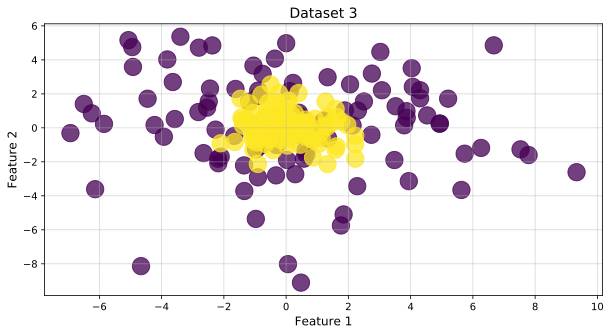

In [19]:
plotarDataset(datasets[datasetAtual-1], "Dataset " + str(datasetAtual))

Assim como o dataset anterior, esse não é linearmente separável.

#### Treinamento com todos os dados

In [20]:
# QUANTIDADE MAXIMA DE EPOCAS DE TREINAMENTO
qtdMaxEpocas = 1000
percentualSemMelhora = 0.35

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = datasets[datasetAtual-1][["feature1", "feature2"]].values
y = datasets[datasetAtual-1]["classe"].values

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

# ARRAY PARA GUARDAR OS OBJETOS MULTINEURON DE CADA TAXA DE APRENDIZAGEM
arrayObjMultiNeuron = []

# PARA CADA VALOR DA TAXA DE APRENDIZAGEM
for taxaAtual in arrayValoresTaxaAprendizagem:
    objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, qtdMaxEpocas=qtdMaxEpocas, percentualSemMelhora=percentualSemMelhora, armazenarEvolucaoNeuronios=True)
    objMultiNeuron.treinar(x, y)
    arrayObjMultiNeuron.append(objMultiNeuron)

#### Critério de parada de cada neurônio para cada taxa de aprendizagem

In [21]:
resultado = plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)
resultado

O critério de parada mais acionado foi o mesmo do dataset anterior, exceto para um neurônio da taxa de aprendizagem mais baixa, que atingiu a quantidade máxima de épocas permitida. Esse comportamento é esperado, já que taxas muito baixas levam mais tempo para convergir os parâmetros dos neurônios.

#### Evolução das acurácias de treinamento e dos pesos

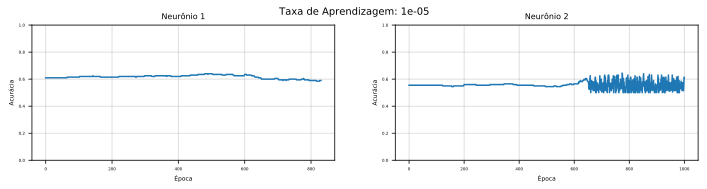

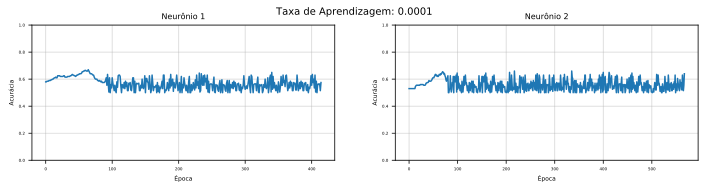

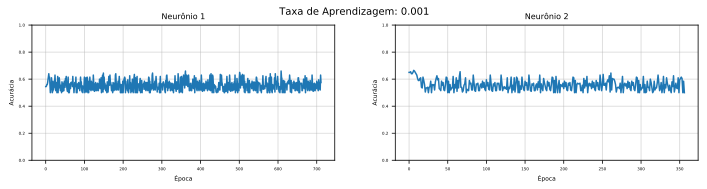

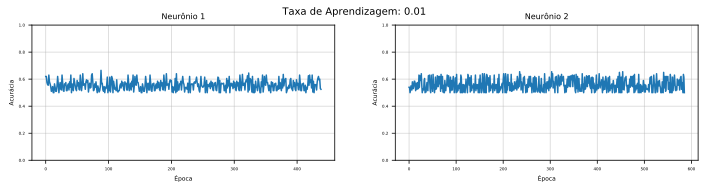

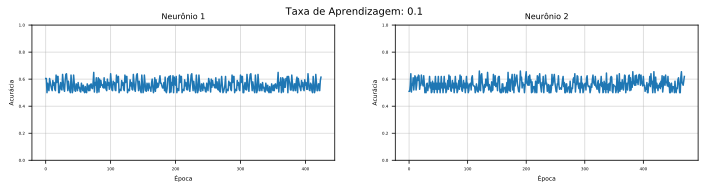

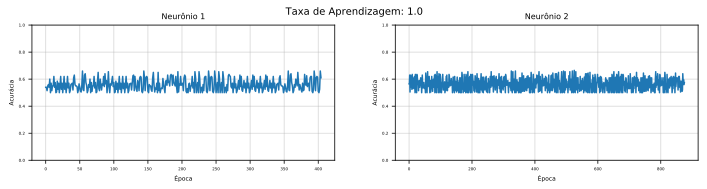

In [22]:
plotarEvolucaoAcuracias(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

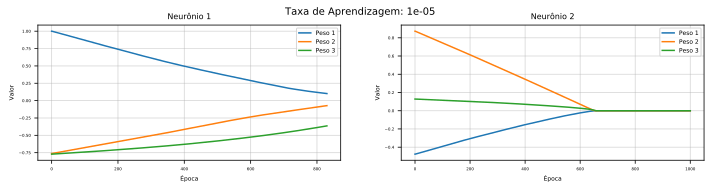

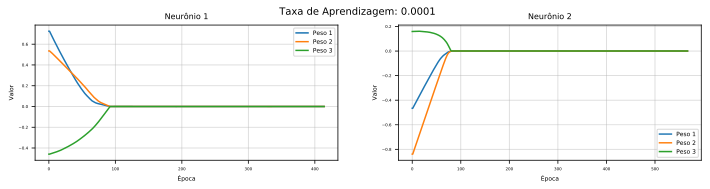

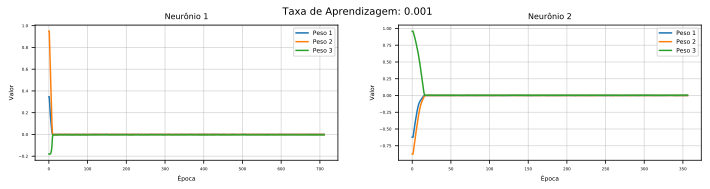

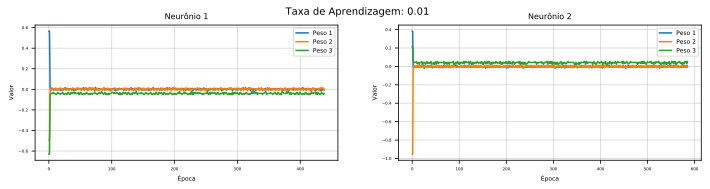

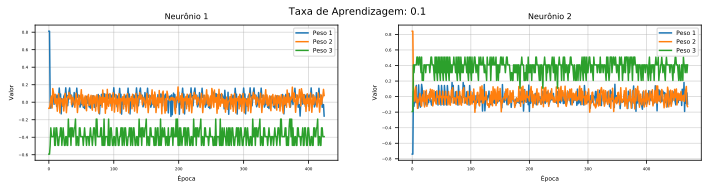

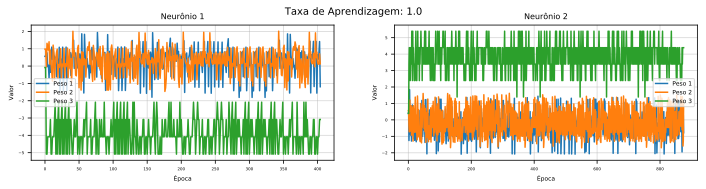

In [23]:
plotarEvolucaoPesos(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

Mais uma vez o comportamento da variância em função da taxa de aprendizagem se apresenta.

### Dataset 4

In [24]:
datasetAtual = 4

#### Visualização

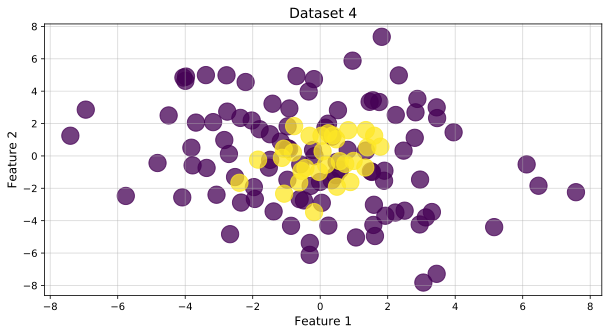

In [25]:
plotarDataset(datasets[datasetAtual-1], "Dataset " + str(datasetAtual))

#### Treinamento com todos os dados

In [26]:
# QUANTIDADE MAXIMA DE EPOCAS DE TREINAMENTO
qtdMaxEpocas = 1000
percentualSemMelhora = 0.35

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = datasets[datasetAtual-1][["feature1", "feature2"]].values
y = datasets[datasetAtual-1]["classe"].values

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

# ARRAY PARA GUARDAR OS OBJETOS MULTINEURON DE CADA TAXA DE APRENDIZAGEM
arrayObjMultiNeuron = []

# PARA CADA VALOR DA TAXA DE APRENDIZAGEM
for taxaAtual in arrayValoresTaxaAprendizagem:
    objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, qtdMaxEpocas=qtdMaxEpocas, percentualSemMelhora=percentualSemMelhora, armazenarEvolucaoNeuronios=True)
    objMultiNeuron.treinar(x, y)
    arrayObjMultiNeuron.append(objMultiNeuron)

#### Critério de parada de cada neurônio para cada taxa de aprendizagem

In [27]:
resultado = plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)
resultado

#### Evolução das acurácias de treinamento e dos pesos

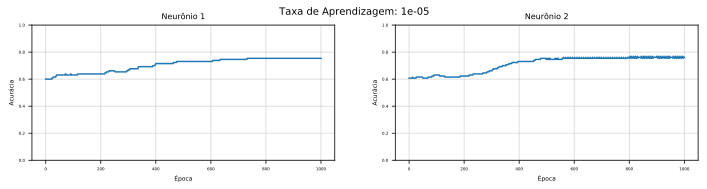

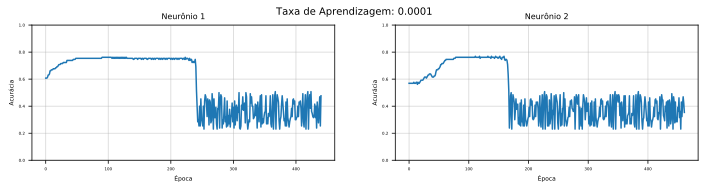

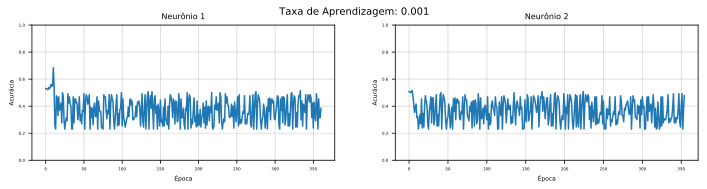

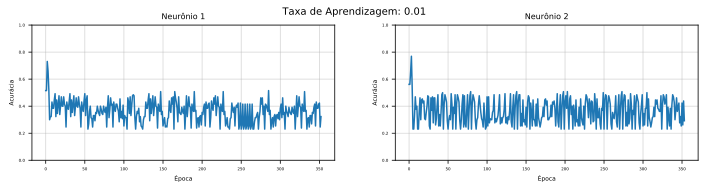

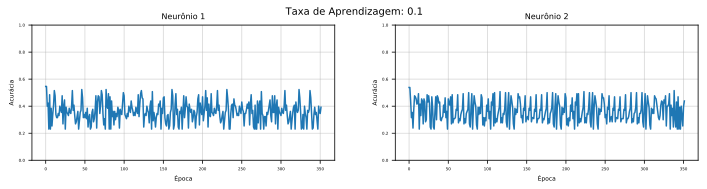

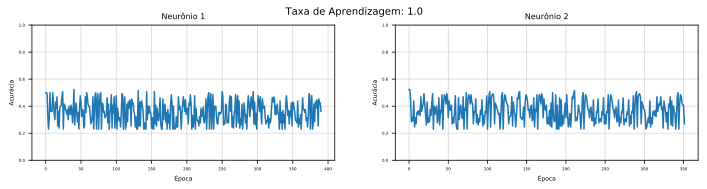

In [28]:
plotarEvolucaoAcuracias(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

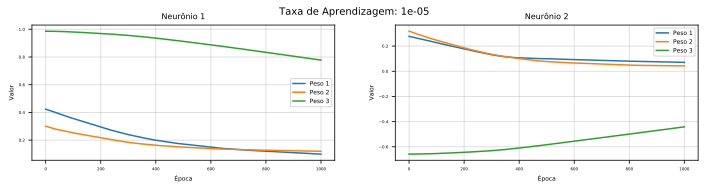

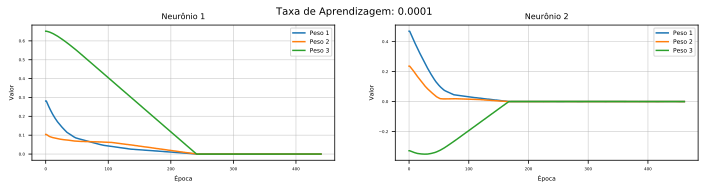

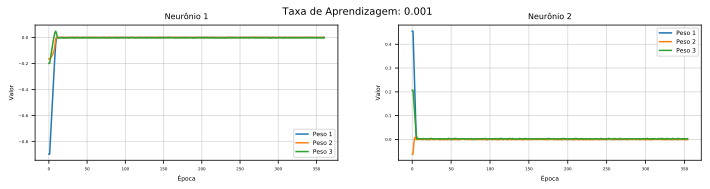

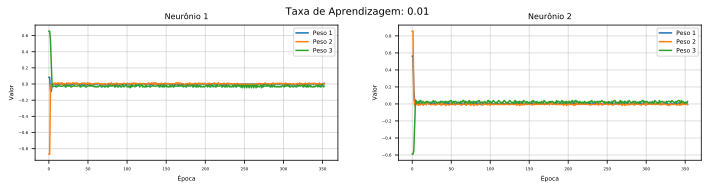

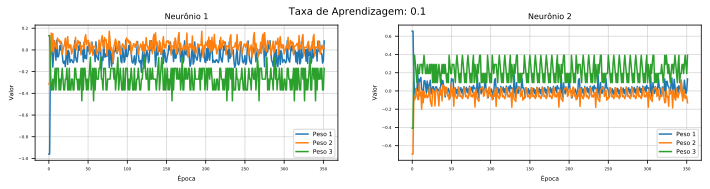

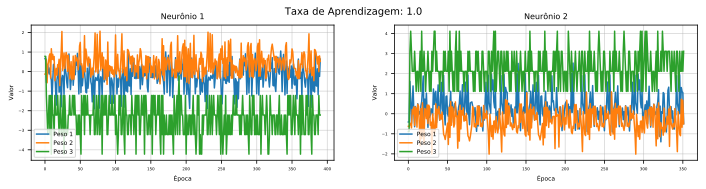

In [29]:
plotarEvolucaoPesos(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

### Dataset 5

In [30]:
datasetAtual = 5

#### Visualização

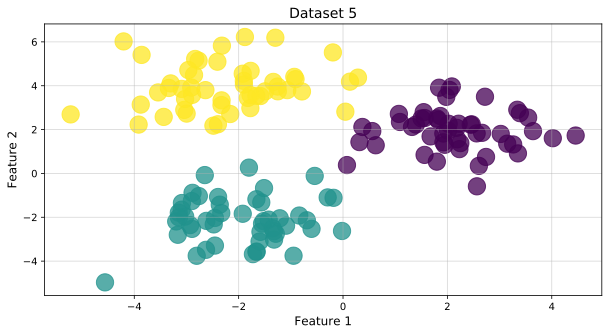

In [31]:
plotarDataset(datasets[datasetAtual-1], "Dataset " + str(datasetAtual))

Dessa vez, um dataset com três classes será utilizado. Como discutido, a implementação do Perceptron Multiclasses emprega um neurônio para cada classe. Logo, três neurônios serão instanciados dessa vez.

Visualmente, é possível imaginar uma reta que separe a classe "Amarelo" das demais, e outra que separe a classe "Verde" das demais. Entretanto, parece não ser possível separar a classe "Roxo". Portanto, espera-se que dois dos três neurônios consigam atingir uma acurácia de treinamento de 100%, mas um dos neurônios não consiguirá atingir esse valor.

#### Treinamento com todos os dados

In [32]:
# QUANTIDADE MAXIMA DE EPOCAS DE TREINAMENTO
qtdMaxEpocas = 1000
percentualSemMelhora = 0.35

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = datasets[datasetAtual-1][["feature1", "feature2"]].values
y = datasets[datasetAtual-1]["classe"].values

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

# ARRAY PARA GUARDAR OS OBJETOS MULTINEURON DE CADA TAXA DE APRENDIZAGEM
arrayObjMultiNeuron = []

# PARA CADA VALOR DA TAXA DE APRENDIZAGEM
for taxaAtual in arrayValoresTaxaAprendizagem:
    objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, qtdMaxEpocas=qtdMaxEpocas, percentualSemMelhora=percentualSemMelhora, armazenarEvolucaoNeuronios=True)
    objMultiNeuron.treinar(x, y)
    arrayObjMultiNeuron.append(objMultiNeuron)

#### Critério de parada de cada neurônio para cada taxa de aprendizagem

In [33]:
resultado = plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)
resultado

Como esperado, dois neurônios obtiveram 100% de acurácia de treinamento, mas o terceiro não. Esse comportamento só não foi observado nas duas taxas de aprendizagem mais baixas, de 1e-5 e 1e-4.

Apesar disso, o neurônio responsável pela classe "Roxo" também obteve acurácias muito altas, de 99.33% na maioria dos casos.

#### Evolução das acurácias de treinamento e dos pesos

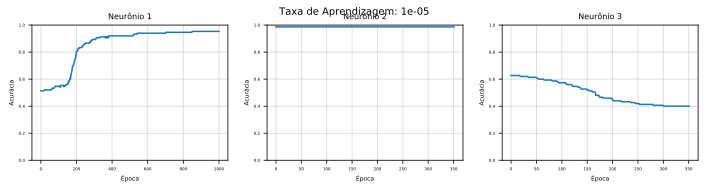

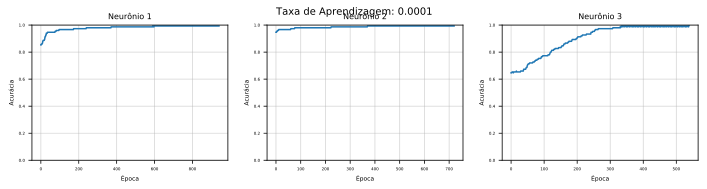

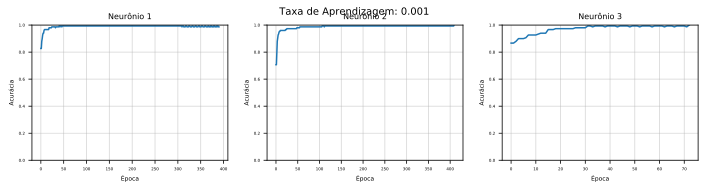

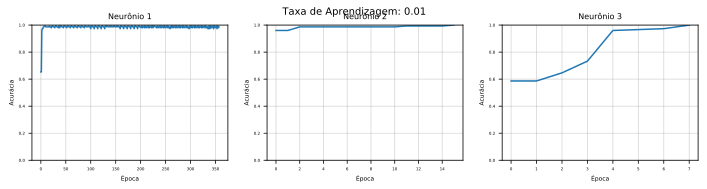

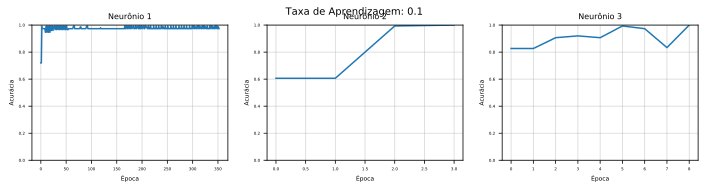

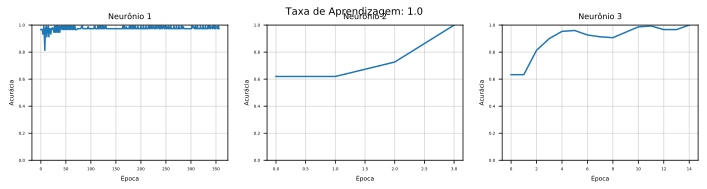

In [34]:
plotarEvolucaoAcuracias(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

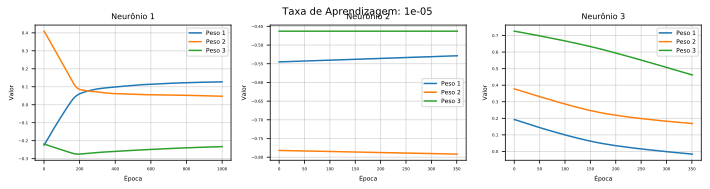

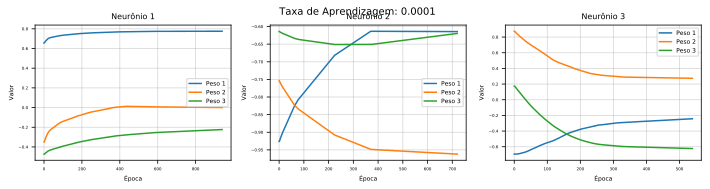

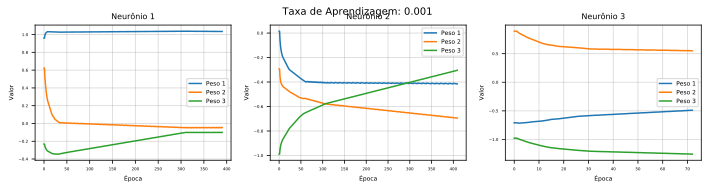

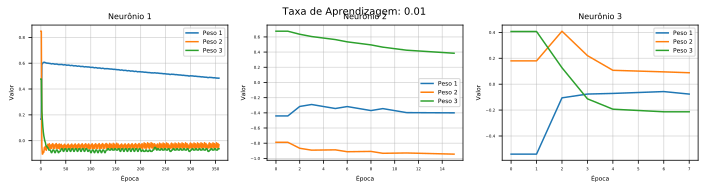

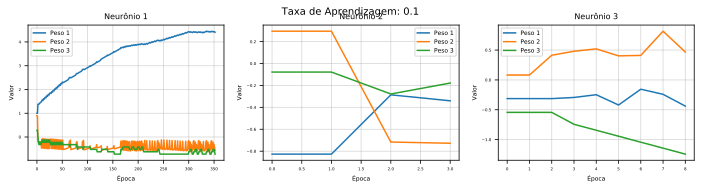

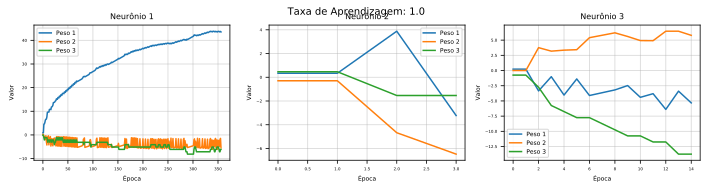

In [35]:
plotarEvolucaoPesos(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

Apesar da variância da evolução dos pesos ser muito maior nas taxas de aprendizagem altas, é interessante notar que essas taxas também conseguiram chegar em 100% de acurácia de treinamento. Isso indica que o dataset não oferece grandes dificuldades.

### Dataset 6

In [36]:
datasetAtual = 6

#### Visualização

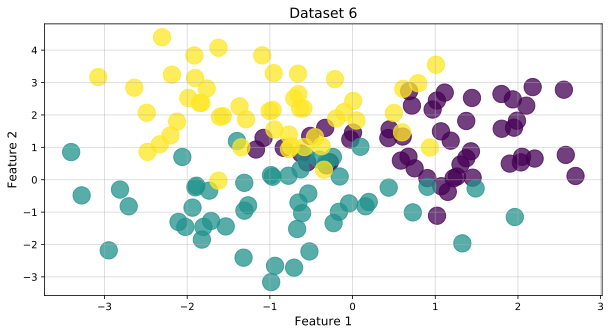

In [37]:
plotarDataset(datasets[datasetAtual-1], "Dataset " + str(datasetAtual))

O último dataset que será utilizado na Questão 1 também apresenta três classes, mas não é linearmente separável. Espera-se que os neurônios não atinjam 100% de acurácia de treinamento como no caso anterior.

#### Treinamento com todos os dados

In [38]:
# QUANTIDADE MAXIMA DE EPOCAS DE TREINAMENTO
qtdMaxEpocas = 1000
percentualSemMelhora = 0.35

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = datasets[datasetAtual-1][["feature1", "feature2"]].values
y = datasets[datasetAtual-1]["classe"].values

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

# ARRAY PARA GUARDAR OS OBJETOS MULTINEURON DE CADA TAXA DE APRENDIZAGEM
arrayObjMultiNeuron = []

# PARA CADA VALOR DA TAXA DE APRENDIZAGEM
for taxaAtual in arrayValoresTaxaAprendizagem:
    objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, qtdMaxEpocas=qtdMaxEpocas, percentualSemMelhora=percentualSemMelhora, armazenarEvolucaoNeuronios=True)
    objMultiNeuron.treinar(x, y)
    arrayObjMultiNeuron.append(objMultiNeuron)

#### Critério de parada de cada neurônio para cada taxa de aprendizagem

In [39]:
resultado = plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)
resultado

#### Evolução das acurácias de treinamento e dos pesos

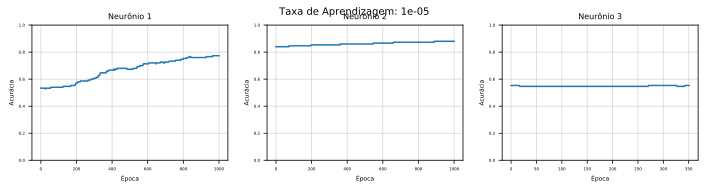

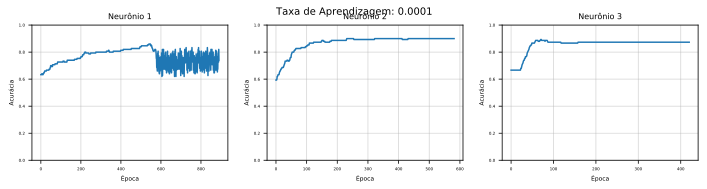

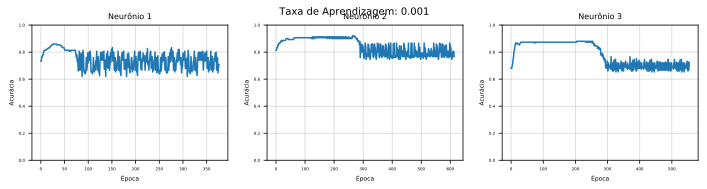

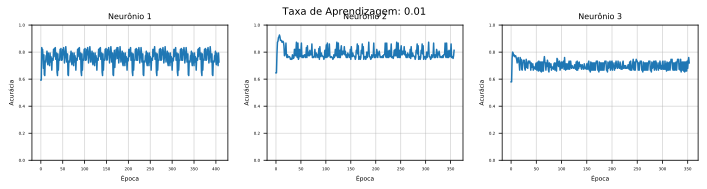

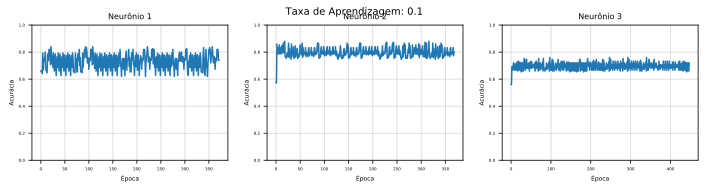

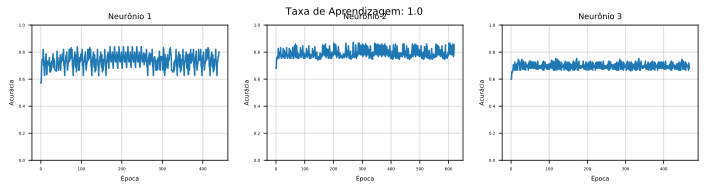

In [40]:
plotarEvolucaoAcuracias(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

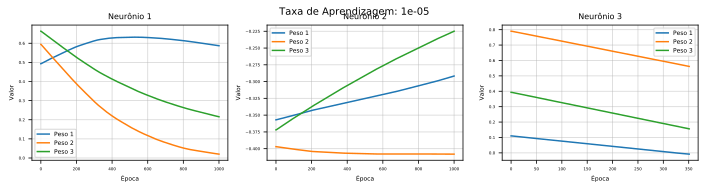

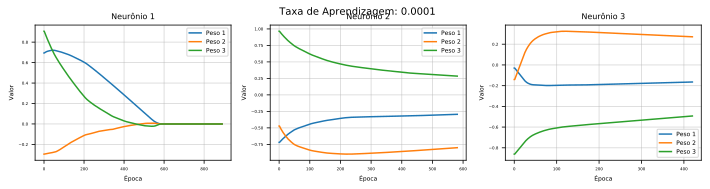

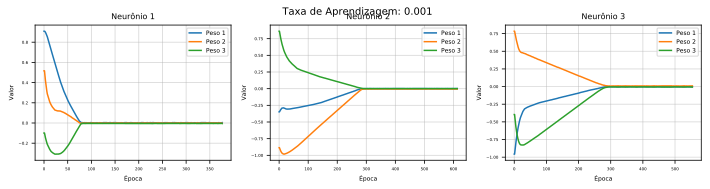

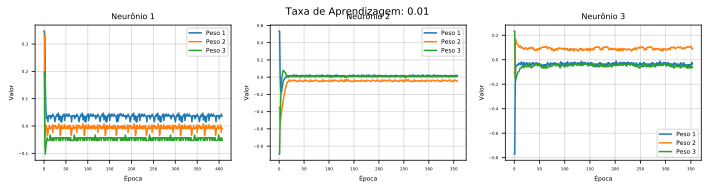

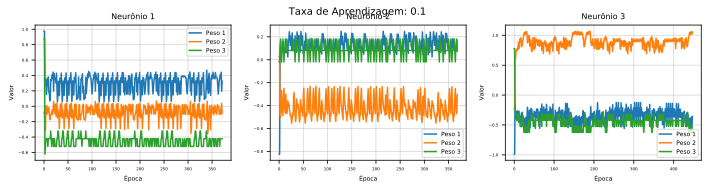

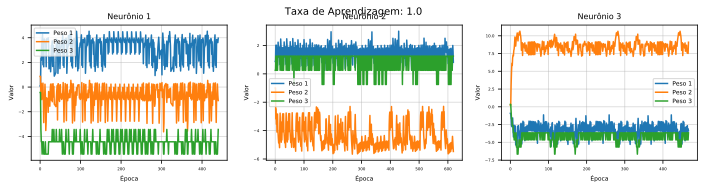

In [43]:
plotarEvolucaoPesos(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron)

## Considerações Finais

O exercício realizado mostrou a influência da taxa de aprendizagem na evolução do treinamento dos neurônios. Verificou-se que taxas de aprendizagem muito pequenas fazem com que os pesos dos neurônios demorem a convergir, sendo necessário utilizar uma quantidade muito maior de épocas de treinamento. Por outro lado, taxas muito altas tendem a dar passos muito largos, pulando os valores ideais para os pesos. 

Como no caso do KNN, em que o número ótimo de vizinhos pode variar de acordo com o dataset, o valor ótimo da taxa de aprendizagem do perceptron também pode variar conforme a disposição dos dados empregados. Essa afirmação será mais explorada na Questão 2, onde o dataset Olivetti Faces será utilizado.

Além disso, nessa questão não se empregou validação cruzada. Todos os dados foram utilizados para treinar os modelos. Na Questão 2, a técnica conhecida por Bootstrap será utilizada.